## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy

from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

In [ ]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Functions

In [2]:
def __get_data(config):


    config['subarray'] = []

    st = Stream()

    for k, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        if net == "II" and sta == "PFO":
            loc, cha = "10", "BH*"
        elif net == "PY" and sta == "PFOIX":
            loc, cha = "", "HH*"
        else:
            loc, cha = "", "BH*"

        print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


        ## querry inventory data
        try:
            inventory = config['fdsn_client'].get_stations(
                                                             network=net,
                                                             station=sta,
                                                             channel=cha,
                                                             starttime=config['tbeg']-20,
                                                             endtime=config['tend']+20,
                                                            )
        except:
            print(" -> Failed to load inventory!")
            inventory = None

        ## try to get waveform data
        try:
            stats = config['fdsn_client'].get_waveforms(
                                                        network=net,
                                                        station=sta,
                                                        location=loc,
                                                        channel=cha,
                                                        starttime=config['tbeg']-20,
                                                        endtime=config['tend']+20,
                                                        attach_response=True,
                                                        )
        except Exception as E:
            print(E) if config['print_details'] else None
            print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
            continue



        ## merge if masked
        if len(stats) > 3:
            print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
            stats.merge(method=1, fill_value="interpolate")


        ## sorting
        stats.sort().reverse()


        ## remove response [VEL -> rad/s | DISP -> rad]
        stats.remove_response(output="VEL")


        #correct mis-alignment
        stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
                                                                 stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
                                                                 stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


        ## trim to interval
#             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

        ## rotate to ZNE
        try:
            if "BPH" in sta:
                stats.rotate(method="->ZNE", inventory=inventory)
        except:
            print(" -> failed to rotate to ZNE")
            continue

        ## rename channels
        if net == "II" and sta == "PFO":
            for tr in stats:
                if tr.stats.channel[-1] == "1":
                    tr.stats.channel = str(tr.stats.channel).replace("1","E")
                if tr.stats.channel[-1] == "2":
                    tr.stats.channel = str(tr.stats.channel).replace("2","N")

        if config['reference_station'] == "PY.PFOIX":
            stats = stats.resample(40)
            stats = stats.trim(config['tbeg']-20, config['tend']+20)


        if station == config['reference_station']:
            ref_station = stats.copy()

        st += stats


    print(st.__str__(extended=True)) if config['print_details'] else None

    ## update subarray stations if data could not be requested for all stations
    if len(st) < 3*len(config['subarray_stations']):
        config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
        config['subarray_stations'] = list(set(config['subarray_stations']))


    print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

    if len(st) == 0:
        return st, Stream(), config
    else:
        return st, ref_station, config

In [3]:
def __add_coordinates(st, config):

    coo = []
    for i, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        if net == "II" and sta == "PFO":
            loc, cha = "10", "BH*"
        elif net == "PY" and sta == "PFOIX":
            loc, cha = "", "HH*"
        else:
            loc, cha = "", "BH*"

        try:
            inven = config['fdsn_client'].get_stations(network=net,
                                                       station=sta,
                                                       channel=cha,
                                                       starttime=config['tbeg'],
                                                       endtime=config['tend'],
                                                       level='response'
                                                      )
        except:
            print(f" -> cannot get inventory for {station}")

        l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
        l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
        height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

        for c in ["Z", "N", "E"]:
            st.select(station=sta, channel=f"*{c}")[0].stats.coordinates = AttribDict({
                                                                                      'latitude': l_lat,
                                                                                      'elevation': height,
                                                                                      'longitude': l_lon
                                                                                       })

    return st

In [4]:
tbeg = "2022-12-31T12:12:07"
tend = "2022-12-31T12:13:20"
submask = "inner"

In [9]:
def __compute_beamforming_pfo(tbeg, tend, submask, plot=False):

    import os
    import numpy as np
    import timeit

    from obspy import UTCDateTime, Stream
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    ## _____________________________________________________

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


            ## querry inventory data
            try:
                inventory = config['fdsn_client'].get_stations(
                                                                 network=net,
                                                                 station=sta,
                                                                 channel=cha,
                                                                 starttime=config['tbeg']-20,
                                                                 endtime=config['tend']+20,
                                                                )
            except:
                print(" -> Failed to load inventory!")
                inventory = None

            ## try to get waveform data
            try:
                stats = config['fdsn_client'].get_waveforms(
                                                            network=net,
                                                            station=sta,
                                                            location=loc,
                                                            channel=cha,
                                                            starttime=config['tbeg']-20,
                                                            endtime=config['tend']+20,
                                                            attach_response=True,
                                                            )
            except Exception as E:
                print(E) if config['print_details'] else None
                print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
                continue


            ## merge if masked
            if len(stats) > 3:
                print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
                stats.merge(method=1, fill_value="interpolate")


            ## sorting
            stats.sort().reverse()


            ## remove response [VEL -> rad/s | DISP -> rad]
            stats.remove_response(output="VEL")


            #correct mis-alignment
            stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
                                                                     stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
                                                                     stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


            ## trim to interval
    #             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

            ## rotate to ZNE
            try:
                if "BPH" in sta:
                    stats.rotate(method="->ZNE", inventory=inventory)
            except:
                print(" -> failed to rotate to ZNE")
                continue

            ## rename channels
            if net == "II" and sta == "PFO":
                for tr in stats:
                    if tr.stats.channel[-1] == "1":
                        tr.stats.channel = str(tr.stats.channel).replace("1","E")
                    if tr.stats.channel[-1] == "2":
                        tr.stats.channel = str(tr.stats.channel).replace("2","N")

            if config['reference_station'] == "PY.PFOIX":
                stats = stats.resample(40)
                stats = stats.trim(config['tbeg']-20, config['tend']+20)


            if station == config['reference_station']:
                ref_station = stats.copy()

            st += stats


        print(st.__str__(extended=True)) if config['print_details'] else None

        ## update subarray stations if data could not be requested for all stations
        if len(st) < 3*len(config['subarray_stations']):
            config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
            config['subarray_stations'] = list(set(config['subarray_stations']))


        print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config


    def __add_coordinates(st, config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            if net == "II" and sta == "PFO":
                loc, cha = "10", "BH*"
            elif net == "PY" and sta == "PFOIX":
                loc, cha = "", "HH*"
            else:
                loc, cha = "", "BH*"

            try:
                inven = config['fdsn_client'].get_stations(network=net,
                                                           station=sta,
                                                           channel=cha,
                                                           starttime=config['tbeg'],
                                                           endtime=config['tend'],
                                                           level='response'
                                                          )
            except:
                print(f" -> cannot get inventory for {station}")

            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            for c in ["Z", "N", "E"]:
                st.select(station=sta, channel=f"*{c}")[0].stats.coordinates = AttribDict({
                                                                                          'latitude': l_lat,
                                                                                          'elevation': height,
                                                                                          'longitude': l_lon
                                                                                           })

        return st

    ## _____________________________________________________

    ## start timer for runtime
    start_timer = timeit.default_timer()


    ## _____________________________________________________

    ## generate configuration object
    config = {}

    ## time period of event
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    ## select the fdsn client for the stations
    config['fdsn_client'] = Client('IRIS')


    ## select stations to consider:
    ## all: [0,1,2,3,4,5,6,7,8,9,10,11,12] | optimal: [0,5,8,9,10,11,12] | inner: [0,1,2,3]
    if submask is not None:
        if submask == "inner":
            config['subarray_mask'] = [0,1,2,3,4]
            config['freq1'] = 0.16  ## 0.00238*3700/100
            config['freq2'] = 16.5 ## 0.25*3700/100
        elif submask == "optimal":
            config['subarray_mask'] = [0,1,6,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
        elif submask == "all":
            config['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
            config['freq1'] = 0.02   ## 0.00238*3700/700
            config['freq2'] = 1.3 # 0.25*3700/700
    else:
        config['subarray_mask'] = [0,1,2,3,4]


    ## decide if information is printed while running the code
    config['print_details'] = False

    ## apply bandpass to data
    config['apply_bandpass'] = True


    ## _____________________
    ## PFO array information

    if config['tbeg'] > UTCDateTime("2023-04-01"):
        config['reference_station'] = 'PY.PFOIX' ## 'BPH01'  ## reference station

        config['array_stations'] = ['PY.PFOIX','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']
    else:
        config['reference_station'] = 'II.PFO' ## 'BPH01'  ## reference station

        config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                                    'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


    config['misorientations'] =  [0, 0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375
                                  ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]


    config['subarray_misorientation'] = [config['misorientations'][i] for i in config['subarray_mask']]
    config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]

    ## ______________________________

    ## beamforming parameters
    config['slow_xmin'] = -3.0
    config['slow_xmax'] = 3.0
    config['slow_ymin'] = -3.0
    config['slow_ymax'] = 0.05
    config['slow_steps'] = 0.05

    config['win_length'] = 2.0 # window length in seconds
    config['win_frac'] = 0.5  # fraction of window to use as steps

    config['freq_lower'] = 0.1
    config['freq_upper'] = 20.0
    config['prewhitening'] = 0  ## 0 or 1


    ## loading data
    st, ref_station, config = __get_data(config)

    ## pre-pprocessing data
    st = st.detrend("demean")
    if config['apply_bandpass']:
        st = st.taper(0.1)
        st = st.filter("bandpass", freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)

    ## add coordinates from inventories
    st = __add_coordinates(st, config)

    ## define parameters for beamforming
    kwargs = dict(

        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=config['slow_xmin'], slm_x=config['slow_xmax'],
        sll_y=config['slow_ymin'], slm_y=config['slow_ymax'],
        sl_s=config['slow_steps'],

        # sliding window properties
        win_len=config['win_length'], win_frac=config['win_frac'],

        # frequency properties
        frqlow=config['freq_lower'], frqhigh=config['freq_upper'], prewhiten=config['prewhitening'],

        # restrict output
        semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',

        ## time period
        stime=config['tbeg']-5, etime=config['tend']+5,
    )

    ## perform beamforming
    out = array_processing(st, **kwargs)


    ## stop times
    stop_timer = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer - start_timer)/60,2)} minutes")

    ## ______________________________
    ## Plotting

    if plot:

        ## PLOT 1 -----------------------------------
        labels = ['rel.power', 'abs.power', 'baz', 'slow']

        out[:, 3][out[:, 3] < 0.0] += 360

        xlocator = mdates.AutoDateLocator()

        fig, ax = plt.subplots(5,1, figsize=(15,10))

        for i, lab in enumerate(labels):
            ax[i].scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
            ax[i].set_ylabel(lab)
            ax[i].set_xlim(out[0, 0], out[-1, 0])
            ax[i].set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
            ax[i].xaxis.set_major_locator(xlocator)
            ax[i].xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

        ax[4].plot(st[0].times()/st[0].times()[-1]*out[:, 0][-1], st[0].data)
        ax[2].set_ylim(0,360)

        fig.autofmt_xdate()
        plt.show();


        ## PLOT 2 -----------------------------------
        cmap = obspy_sequential

        # make output human readable, adjust backazimuth to values between 0 and 360
        t, rel_power, abs_power, baz, slow = out.T
        baz[baz < 0.0] += 360

        # choose number of fractions in plot (desirably 360 degree/N is an integer!)
        N = 36
        N2 = 30
        abins = np.arange(N + 1) * 360. / N
        sbins = np.linspace(0, 3, N2 + 1)


        # sum rel power in bins given by abins and sbins
        hist, baz_edges, sl_edges = \
            np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

        # transform to radian
        baz_edges = np.radians(baz_edges)

        # add polar and colorbar axes
        fig = plt.figure(figsize=(8, 8))
        cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
        ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location("N")

        dh = abs(sl_edges[1] - sl_edges[0])
        dw = abs(baz_edges[1] - baz_edges[0])

        # circle through backazimuth
        for i, row in enumerate(hist):
            bars = ax.bar((i * dw) * np.ones(N2),
                          height=dh * np.ones(N2),
                          width=dw, bottom=dh * np.arange(N2),
                          color=cmap(row / hist.max()))

        ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
        ax.set_xticklabels(['N', 'E', 'S', 'W'])

        # set slowness limits
        ax.set_ylim(0, 3)
        [i.set_color('grey') for i in ax.get_yticklabels()]
        ColorbarBase(cax, cmap=cmap,
                     norm=Normalize(vmin=hist.min(), vmax=hist.max()))

        plt.show();

    ## prepare output
    baz = out[:, 3]
    baz[baz < 0.0] += 360

    output = {}
    output['t_win'] = out[:, 0]
    output['rel_pwr'] = out[:, 1]
    output['abs_pwr'] = out[:, 2]
    output['baz'] = baz
    output['slow'] = out[:, 4]

    return output


 -> Runtime: 0.54 minutes


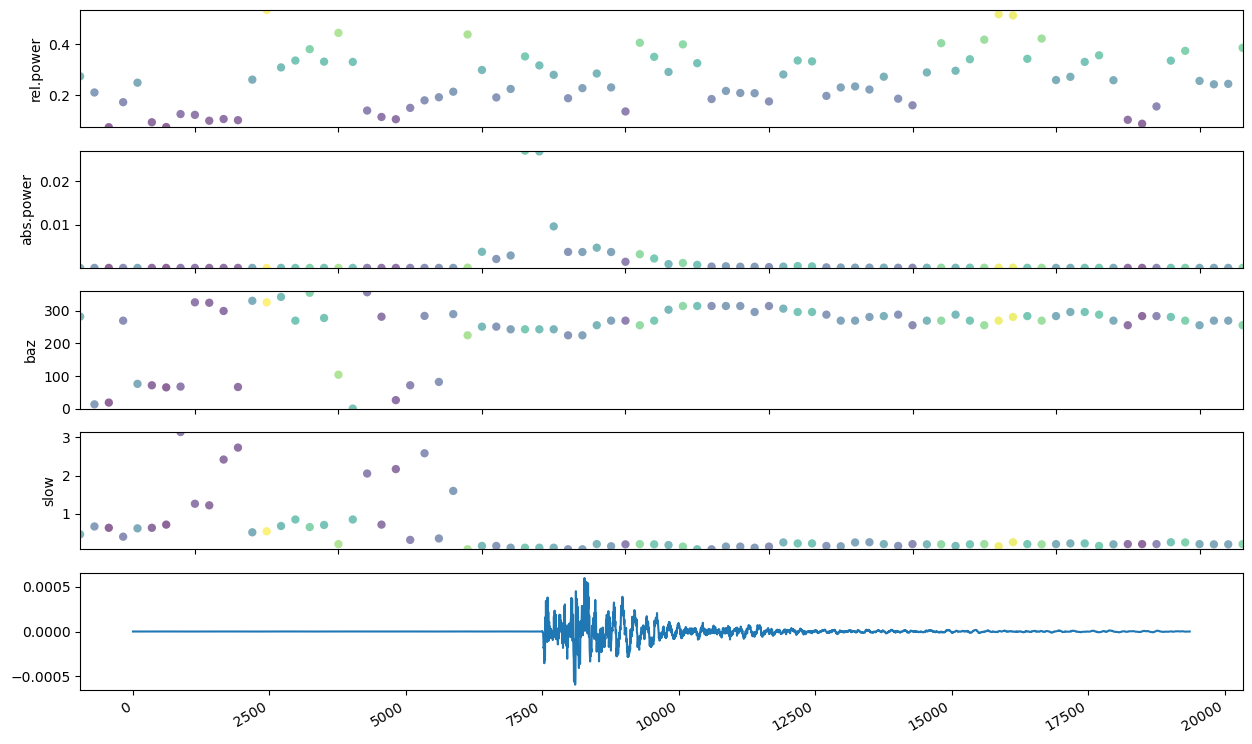

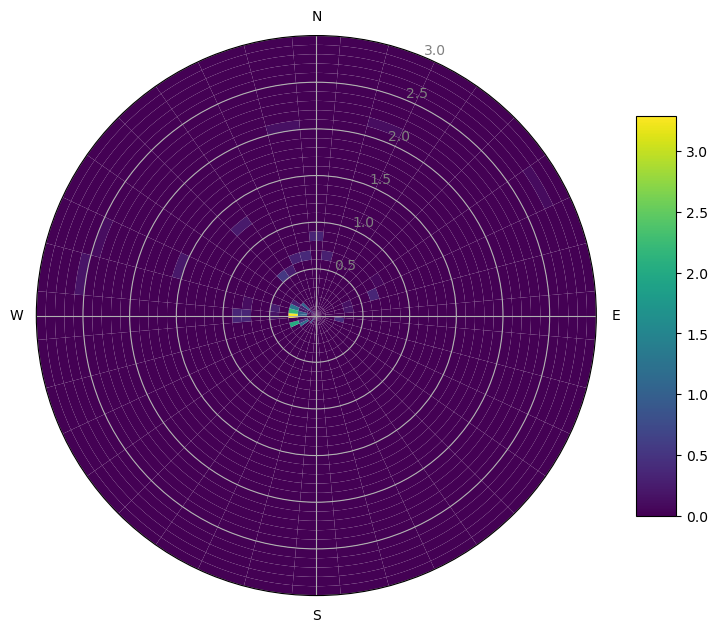

In [10]:
out = __compute_beamforming_pfo(tbeg, tend, submask, plot=True)

## test one event

In [7]:
tbeg = "2022-12-31T12:12:07"
tend = "2022-12-31T12:13:20"
submask = "inner"

In [8]:
st, ref_station, config = __get_data(config)

NameError: name 'config' is not defined

In [ ]:
st = __add_coordinates(st, config)

In [ ]:
out = array_processing(st, **kwargs)

In [ ]:
# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure(figsize=(11,8))
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))


fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

## Timeline Plot

In [ ]:
labels = ['rel.power', 'abs.power', 'baz', 'slowness']

# xlocator = mdates.AutoDateLocator()

t_win = (out[:, 0] - out[:, 0][0]) * 0.02
rel_pwr = out[:, 1]
abs_pwr = out[:, 2]
baz = out[:, 3]
slow = out[:, 4]

fig, ax = plt.subplots(5, 1, figsize=(15,10), sharex=False)

ax[0].plot(st[0].times(), st[0].data)

ax[1].scatter(t_win, rel_pwr, c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
ax[1].set_ylabel("rel. power")

ax[2].scatter(t_win, abs_pwr, c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
ax[2].set_ylabel("abs. power")

ax[3].scatter(t_win, baz, c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
ax[3].set_ylabel("baz (°)")
ax[3].set_ylim(0,360)

ax[4].scatter(t_win, slow, c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
ax[4].set_ylabel("slowness")


# ax[i].set_xlim(out[0, 0], out[-1, 0])
# ax[i].set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
# ax[i].xaxis.set_major_locator(xlocator)
# ax[i].xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))


# fig.autofmt_xdate()
# fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show();

## Polar Plot

In [ ]:

cmap = obspy_sequential

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360

# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 36
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)


# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()